# Tutorial 7 (Introduction to AI)

# MLP. Training neural networks

# Part 1. Early Stopping and Regularization techniques


Training a deep neural network that can generalize well to new data is a challenging problem.

A model with too little capacity cannot learn the problem, whereas a model with too much capacity can learn it too well and overfit the training dataset. Both cases result in a model that does not generalize well.

This motivates the use of **regularisation** during training in order to reduce the generalization error.  The application of these techniques might give a larger model, but not only reduce overfitting, they can also lead to faster optimization of the model and better overall performance.

## 1. Early stopping

Before we look at regularisation, we will pause to look at one commonly used training technique.

Training neural networks can be expensive, it terms of time and resource.  In last week's exercises we specified the number of epochs training was to run for, set it running and left it at that.  This might mean leaving the network training once it has converged to a solution.  This will lead to unnecessary training time, and possibly to overfitting.

This motivates *early stopping*, where a stopping criteria (in terms of the error) is specified and once this criteria is met, training ceases.

In Keras this is specified as a callback, and you might need to set the following parameters:

* monitor -- what quantity is being measure, typically *loss*
* min_delta -- a change in the monitor less than this value doesn't count as an improvement
* patience -- the number of epochs of no improvement to trigger early stopping
* mode -- typically *auto*

We will now apply this to the auto_mpg example we looked at last week.  First, we include the helper functions again.

In [ ]:
import base64
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

Next let's recall one of the models from last week.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split

path = "../ex1/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
X,y = to_xy(df,"mpg")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=0,epochs=200)

pred = model.predict(X_test)
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 4.66825008392334


Now the callback is added, with the definition of **monitor** defining early stopping on *loss*.  

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(X_train,y_train,callbacks=[monitor],verbose=2,epochs=200)
pred = model.predict(X_test)
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Epoch 1/200
10/10 - 0s - loss: 38153.0508
Epoch 2/200
10/10 - 0s - loss: 5697.9268
Epoch 3/200
10/10 - 0s - loss: 2882.6287
Epoch 4/200
10/10 - 0s - loss: 1319.1770
Epoch 5/200
10/10 - 0s - loss: 400.8026
Epoch 6/200
10/10 - 0s - loss: 372.4380
Epoch 7/200
10/10 - 0s - loss: 251.9752
Epoch 8/200
10/10 - 0s - loss: 203.4046
Epoch 9/200
10/10 - 0s - loss: 204.4814
Epoch 10/200
10/10 - 0s - loss: 193.0516
Epoch 11/200
10/10 - 0s - loss: 187.4896
Epoch 12/200
10/10 - 0s - loss: 183.8933
Epoch 13/200
10/10 - 0s - loss: 180.0732
Epoch 14/200
10/10 - 0s - loss: 176.4046
Epoch 15/200
10/10 - 0s - loss: 171.7619
Epoch 16/200
10/10 - 0s - loss: 168.7182
Epoch 17/200
10/10 - 0s - loss: 162.7848
Epoch 18/200
10/10 - 0s - loss: 157.5928
Epoch 19/200
10/10 - 0s - loss: 153.0657
Epoch 20/200
10/10 - 0s - loss: 148.5979
Epoch 21/200
10/10 - 0s - loss: 146.7766
Epoch 22/200
10/10 - 0s - loss: 142.1727
Epoch 23/200
10/10 - 0s - loss: 139.3495
Epoch 24/200
10/10 - 0s - loss: 138.8910
Epoch 25/200
10/10 -

Observe that training has terminated early.  You might experiement with adjusting *min_delta* and *patience* and observe changes in behaviour.

## 2. Dropout regularisation

Most neural network frameworks implement dropout as a separate layer.  Dropout layers function as a regular, densely connected neural network layer.  The only difference is that the dropout layers will periodically drop some of their neurons during training.  You can use dropout layers on regular feedforward neural networks.

The usual hyper-parameters for a dropout layer are the following:

* Neuron Count
* Activation Function
* Dropout Probability

The neuron count and activation function hyper-parameters work exactly the same way as their corresponding parameters in the dense layer we studied last week. The neuron count simply specifies the number of neurons in the dropout layer.  The dropout probability indicates the likelihood of a neuron dropping out during the training iteration.  Just as it does for a dense layer, the program specifies an activation function for the dropout layer.

![class_9_dropout.png](attachment:class_9_dropout.png)

The specified percentage of neurons will be masked during each training step.  All neurons return after training is complete.  To make use of dropout in Keras use the **Dropout** layer and specify a dropout probability.  This is the percent of neurons to be dropped.  Typically this is a low value, such as 0.1.

In [ ]:
# Keras with Dropout (Regression)

from matplotlib.pyplot import figure, show
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

path = "../ex1/"

# Set the desired TensorFlow output level for this example
#tf.logging.set_verbosity(tf.logging.ERROR)

#read in file, as we have done previously
filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
X,y = to_xy(df,"mpg")

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

model = Sequential()

#model.add(Dropout(0.1)) #applies to layer before ie input here
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit(X_train,y_train,callbacks=[monitor],verbose=2,epochs=1000)
pred = model.predict(X_test)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
model.summary()

Epoch 1/1000
10/10 - 0s - loss: 21154.7441
Epoch 2/1000
10/10 - 0s - loss: 19572.4727
Epoch 3/1000
10/10 - 0s - loss: 20680.5859
Epoch 4/1000
10/10 - 0s - loss: 21043.4688
Epoch 5/1000
10/10 - 0s - loss: 17379.6016
Epoch 6/1000
10/10 - 0s - loss: 15036.0391
Epoch 7/1000
10/10 - 0s - loss: 15061.4326
Epoch 8/1000
10/10 - 0s - loss: 12802.5459
Epoch 9/1000
10/10 - 0s - loss: 12276.3135
Epoch 10/1000
10/10 - 0s - loss: 13513.6377
Epoch 11/1000
10/10 - 0s - loss: 9924.6152
Epoch 12/1000
10/10 - 0s - loss: 9693.6523
Epoch 13/1000
10/10 - 0s - loss: 8254.5488
Epoch 14/1000
10/10 - 0s - loss: 8511.5508
Epoch 15/1000
10/10 - 0s - loss: 6954.7295
Epoch 16/1000
10/10 - 0s - loss: 8178.8760
Epoch 17/1000
10/10 - 0s - loss: 7519.5991
Epoch 18/1000
10/10 - 0s - loss: 5768.7109
Epoch 19/1000
10/10 - 0s - loss: 6386.8755
Epoch 20/1000
10/10 - 0s - loss: 6398.5962
Epoch 21/1000
10/10 - 0s - loss: 5029.8008
Epoch 22/1000
10/10 - 0s - loss: 6477.8823
Epoch 23/1000
10/10 - 0s - loss: 4925.1577
Epoch 24/1

Notice that on a typical run, Dropout here leads to shorter training time, though not necessarily better results.

## 3. L1 (Lasso) regularization

L1 Regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) is used to create sparsity in the neural network. In other words, the L1 algorithm will push many weight connections to near 0.  Dropping weighted connections will create a sparse neural network.

Feature selection is a useful by product of sparse neural networks. Features are the values that the training set provides to the input neurons.  Once all the weights of an input neuron reach 0, you might conclude that the feature is unnecessary.  If your data set has a large number of input features that may not be needed, L1 regularization can help the neural network detect and ignore unnecessary features.

L1 is implemented by adding the following error to the objective to minimize:

$$ E_1 = \alpha \sum_w{ |w| } $$

The following code demonstrates Lasso regression.  Notice the effect on the coefficients, four of which are close to zero.

Final score (RMSE): 3.0604023933410645


,coef,positive
cylinders,-0.012994,False
weight,-0.007328,False
horsepower,-0.002715,False
displacement,0.011601,True
acceleration,0.114391,True
origin,0.708222,True
year,0.777480,True


Intercept: [-18.50667]


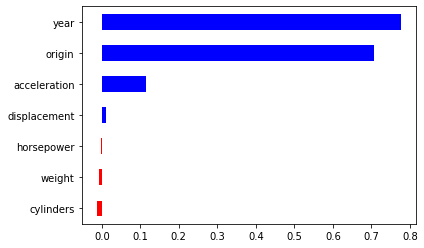

In [ ]:
import sklearn
from sklearn.linear_model import Lasso

# Simple function to evaluate the coefficients of a regression
%matplotlib inline
from IPython.display import display, HTML

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(X_train,y_train)
# Predict
pred = regressor.predict(X_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)


## 4. L2 (Ridge) regularization

You should use Tikhonov/Ridge/L2 regularization when you are less concerned about creating a sparce network and are more concerned about low weight values.  The lower weight values will typically lead to less overfitting.

$$ E_2 = \alpha \sum_w{ w^2 } $$

Like the L1 algorithm, the $\alpha$ value determines how important the L2 objective is compared to the neural network’s error.  Typical L2 values are below 0.1 (10%).  The main calculation performed by L2 is the summing of the squares of all of the weights.  The bias values are not summed.

## 5. Keras and L1/L2

L1 and L2 regularization are two common regularization techniques that can reduce the effects of overfitting.  The regularization algorithm is attached to the training algorithm by adding an additional objective.  

As discussed above, both of these algorithms work by adding a weight penalty to the neural network training.  This penalty encourages the neural network to keep the weights to small values, and L1 and L2 calculate this penalty differently.  For gradient-descent-based algorithms, such as backpropagation, you can add this penalty calculation to the calculated gradients.

Both L1 and L2 work differently in the way that they penalize the size of a weight.  L2 will force the weights into a pattern similar to a Gaussian distribution; the L1 will force the weights into a pattern similar to a Laplace distribution, as demonstrated the following:

![L1 vs L2](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_l1_l2.png "L1 vs L2")

As you can see, L1 algorithm is more tolerant of weights further from 0, whereas the L2 algorithm is less tolerant.  You also need to note that both L1 and L2 count their penalties based only on weights; they do not count penalties on bias values.

The code below demonstrates that regularizers can be added to a layer in a neural network (and can be applied to the weight (which is slightly more usual) or to the activation function.

In [ ]:
from tensorflow.keras import regularizers

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
X,y = to_xy(df,"mpg")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu',kernel_regularizer=regularizers.l1(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',activity_regularizer=regularizers.l2(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',
#                kernel_regularizer=regularizers.l2(0.01),
#                activity_regularizer=regularizers.l1(0.01),activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit(X_train,y_train,callbacks=[monitor],verbose=0,epochs=1000)
pred = model.predict(X_test)
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Epoch 00047: early stopping
Final score (RMSE): 3.7053940296173096


The final version of this code that we shall look at is below.  This has two differences.
 - The first is that the call to fit includes "validation_split".  In these examples so far, we have simply split our data into training data and testing data.  We might well want to split data into training, validation and testing.  validation_split allows a proportion of the training data to be held back to validation.  It can be interesting to see whether the validation results follow the training results, which would be an indication of a model with good generalisation
 - The second is that code has been added to plot training.  Here, epochs is plotted against loss/val_loss.  Notice that the call to fit is now giving a return value, and that represents training information (it's called "training_trace" in this example).  From this we can access loss and val_loss, the latter being the error on the validation data.

Finally, note that early stopping might perhaps instead have been defined on val_loss, rather than loss.

Epoch 00035: early stopping
Final score (RMSE): 4.988840579986572


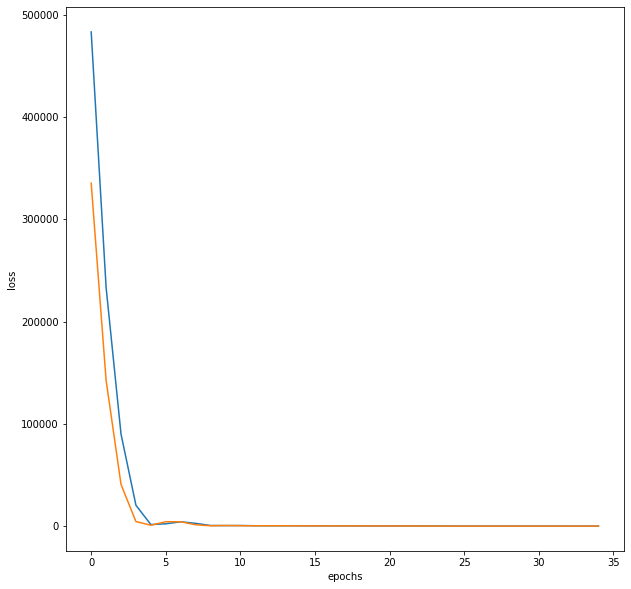

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu',kernel_regularizer=regularizers.l1(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',activity_regularizer=regularizers.l2(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',
#                kernel_regularizer=regularizers.l2(0.01),
#                activity_regularizer=regularizers.l1(0.01),activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
#note the return here, with the data from training stroed in training_trace
#also note the validation split
training_trace = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=0,epochs=1000)
pred = model.predict(X_test)
# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

## plot the loss on the training data, and also the validation data
plt.figure(figsize=(10,10))

plt.plot(training_trace.history['loss'])
plt.plot(training_trace.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()